In [20]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from Dataset import *
from torchvision import transforms
from p_tqdm import p_umap
from functools import partial


In [21]:
frame_width,frame_height = 250,150
x,y = 500,750
pt1_L = (x, y)
pt2_L = (x+frame_width, y+frame_height)
x,y = 1450,840
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
x,y = 1000,840
pt1_M = (x, y)
pt2_M = (x+frame_width, y+frame_height)
ROI_L, ROI_R, ROI_M = [pt1_L, pt2_L], [pt1_R, pt2_R], [pt1_M, pt2_M]

In [21]:
# Process the dataset
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
activation_table_path = r"D:\LiDAR_Data\2ndPHB\Video\activation_0113.xlsx"
output_dir = r"D:\LiDAR_Data\2ndPHB\Video\Dataset"
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
time_window = 3 # seconds
# Load the Excel data
activation_table = pd.read_excel(r'D:\LiDAR_Data\2ndPHB\Video\activation_0113.xlsx')
excel_file_1 = r"D:\LiDAR_Data\2ndPHB\Video\HAWK Pedestrian Behavior.xlsx"
student_file = pd.read_excel(excel_file_1)
fps = 10

In [22]:
"""
Conbine the my labels and high school student labels
"""
student_activation_L = student_file.loc[(student_file.Bound == 'N') & (student_file.loc[:,'Pressed?'] == 'Y')].copy()
student_activation_R = student_file.loc[(student_file.Bound == 'S') & (student_file.loc[:,'Pressed?'] == 'Y')].copy()
# uniform the column names and data format
# combine Date column and Time column in student_activation_L and student_activation_R, and convert to YYYYMMDD_HHMMSS format
timestamp = student_activation_L['Date'].astype(str) + '_' + student_activation_L['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
# eliminate '-' in the timestamp
timestamp = timestamp.str.replace('-','')
student_activation_L.loc[:,'timestamp'] = timestamp
timestamp = student_activation_R['Date'].astype(str) + '_' + student_activation_R['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
timestamp = timestamp.str.replace('-','')
student_activation_R.loc[:,'timestamp'] = timestamp
# combine student_activation_L and student_activation_R to activation_df
student_activation_L.loc[:, 'location'] = 'L'
student_activation_R.loc[:, 'location'] = 'R'
student_activation_L = student_activation_L.loc[:,['timestamp','location']]
student_activation_R = student_activation_R.loc[:,['timestamp','location']]
student_activation = pd.concat([student_activation_L, student_activation_R], axis=0)
student_activation['status'] = 2
activation_df = pd.concat([activation_table, student_activation], axis=0)
# drop duplicates
activation_df = activation_df.drop_duplicates(subset=['timestamp','location'], keep='first')
activation_df = activation_df.reset_index(drop=True)

In [23]:
""" identify unvisited video files"""
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
total_video_list = os.listdir(video_dir)
total_record_list = activation_df["timestamp"].tolist()
# convert to timestamp
total_record_list = [datetime.strptime(record, "%Y%m%d_%H%M%S") for record in total_record_list]
total_record_list_ = []
for record in total_record_list:
    record = record - timedelta(minutes = record.minute % 5)
    record = record.replace(second = 0 )
    total_record_list_.append(record)
unique_record_list = list(set(total_record_list_))
unvisited_video_list = []
for video in total_video_list:
    video_start_timestamp = video[22:].split(".")[0]
    video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
    if video_start_timestamp not in unique_record_list:
        unvisited_video_list.append(video)
save_path = r'D:\LiDAR_Data\2ndPHB\Video\unvisited_video_list_0123.csv'
df = pd.DataFrame(unvisited_video_list)
df.to_csv(save_path, index = False)

In [58]:
start_frames, end_frames, date_times, save_names = [], [], [], []
fps = 10
for _, row in tqdm(activation_df.iterrows()):
    record_timestamp = row["timestamp"]
    location = row["location"]
    label = row["status"]
    # convert to datetime object
    record_timestamp = datetime.strptime(record_timestamp, "%Y%m%d_%H%M%S")
    
    # Match the video file with the timestamp
    for video_file in os.listdir(video_dir):
        video_start_timestamp = video_file[22:].split(".")[0]
        # convert to datetime object
        video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
        video_end_timestamp = video_start_timestamp + timedelta(seconds=60 * 5)
        if video_start_timestamp <= record_timestamp <= video_end_timestamp:
            # convert video_start_timestamp to '%Y-%m-%d-%H-%M-%S'
            video_start_timestamp_str = video_start_timestamp.strftime('%Y-%m-%d-%H-%M-%S')
            # window screening for the video clips making sure the record_timestamp is each 30 seconds
            screen_start_frame = int((record_timestamp - video_start_timestamp).seconds * fps) - (time_window - 1) * fps
            for step in range(2,18): # 2 frame margin for consevative screening
                start_frame = int(screen_start_frame + step)
                end_frame = start_frame + time_window * fps
                start_frames.append(start_frame)
                end_frames.append(end_frame)
                date_times.append(video_start_timestamp_str)
                save_names.append(f"{label}_{video_start_timestamp_str}_{start_frame}_{location}.mp4")

1077it [00:09, 111.97it/s]


In [74]:
frame_width,frame_height = 250,150
x,y = 500,750
pt1_L = (x, y)
pt2_L = (x+frame_width, y+frame_height)
x,y = 1450,840
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
x,y = 1000,840
pt1_M = (x, y)
pt2_M = (x+frame_width, y+frame_height)
ROI_L, ROI_R, ROI_M = [pt1_L, pt2_L], [pt1_R, pt2_R], [pt1_M, pt2_M]
""" Select ROI for the video clips"""
video_path = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo\00_00_192.168.1.108_1_20241208_205000.avi'
cap = cv2.VideoCapture(video_path)
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
    break
cap.release()
frames = np.array(frames) # (seq_len, h, w, c)
test_img = frames[0].copy()
# draw the ROI
pt1_L, pt2_L = ROI_L
pt1_R, pt2_R = ROI_R
pt1_M, pt2_M = ROI_M
cv2.rectangle(test_img, pt1_L, pt2_L, (255, 0, 0), 2)
cv2.rectangle(test_img, pt1_R, pt2_R, (255, 0, 0), 2)
cv2.rectangle(test_img, pt1_M, pt2_M, (255, 0, 0), 2)
plt.imshow(test_img)
# draw a rectangle around the object
plt.show()
# crop the image
cropped_img = test_img[pt1_L[1]:pt2_L[1], pt1_L[0]:pt2_L[0]]
plt.imshow(cropped_img)
plt.show()
cropped_img = test_img[pt1_R[1]:pt2_R[1], pt1_R[0]:pt2_R[0]]
plt.imshow(cropped_img)
plt.show()
cropped_img = test_img[pt1_M[1]:pt2_M[1], pt1_M[0]:pt2_M[0]]
plt.imshow(cropped_img)
plt.show()

""" Save the video clips"""



In [28]:
# make the dataframe
# data = {"date_time": date_times, "start_frame": start_frames, "end_frame": end_frames, "save_name": save_names}
# df = pd.DataFrame(data)
# video file format: 00_00_192.168.1.108_1_20241204_224500.avi
target_video_paths = []
target_frames = []
save_names = []
locations = []
for date_time,g in df.groupby("date_time"):
    # convert date_time to YYYYMMDD_HHMMSS
    date_time = datetime.strptime(date_time, "%Y-%m-%d-%H-%M-%S").strftime("%Y%m%d_%H%M%S")
    video_file = f"00_00_192.168.1.108_1_{date_time}.avi"
    video_path = os.path.join(video_dir, video_file)
    target_video_paths.append(video_path)
    target_start_frames = g["start_frame"].tolist()
    target_end_frames = g["end_frame"].tolist()
    target_frames.append(np.c_[target_start_frames, target_end_frames])
    save_names.append(g["save_name"].tolist())
    locations.append(g["save_name"].str[-5].tolist())
    # break


In [15]:
frame_width,frame_height = 250,150
x,y = 500,750
pt1_L = (x, y)
pt2_L = (x+frame_width, y+frame_height)
x,y = 1450,840
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
x,y = 1000,840
pt1_M = (x, y)
pt2_M = (x+frame_width, y+frame_height)
ROI_L, ROI_R, ROI_M = [pt1_L, pt2_L], [pt1_R, pt2_R], [pt1_M, pt2_M]
def write_video(output_path, frames, fourcc, fps, frame_width, frame_height,location):
    """
    Writes a video file using OpenCV.

    Args:
        output_path (str): Path to save the video.
        frames (list): List of frames to write.
        fourcc (int): Codec.
        fps (int): Frames per second.
        frame_width (int): Width of the frame.
        frame_height (int): Height of the frame.
    """
    # Set up VideoWriter for saving the output
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    for frame in frames:
        if location == 'L':
            # crop the image to the ROI
            frame = frame[ROI_L[0][1]:ROI_L[1][1], ROI_L[0][0]:ROI_L[1][0]]
        elif location == 'R':
            frame = frame[ROI_R[0][1]:ROI_R[1][1], ROI_R[0][0]:ROI_R[1][0]]
        out.write(frame)
    # Release resources
    out.release()

def clip_single_video(input_video_path, save_names, target_frames, locations, output_folder):
    """
    Clips a video using OpenCV based on start and end timestamps.

    Args:
        input_path (str): Path to the input video file.
        output_path (str): Path to save the clipped video.
        start_time (float): Start time in seconds.
        end_time (float): End time in seconds.
    """
    # Open the video file
    cap = cv2.VideoCapture(input_video_path)
    
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec

    init_frame = target_frames[:,0].min()
    ending_frame = target_frames[:,1].max()
    current_frame = init_frame
    # Set the starting position of the video
    cap.set(cv2.CAP_PROP_POS_FRAMES, init_frame)

    frames = []
    frame_inds = []
    while current_frame <= ending_frame:
        ret, frame = cap.read()
        if not ret:
            # print("End of video reached or error reading frame.")
            break
        frames.append(frame)
        frame_inds.append(current_frame)
        current_frame += 1
    for i in range(len(target_frames)):
        start_frame = target_frames[i,0]
        end_frame = target_frames[i,1]
        start_ind = np.where(frame_inds == start_frame)[0][0]
        end_ind = np.where(frame_inds == end_frame)[0][0]
        save_name = save_names[i]
        location = locations[i]
        output_path = os.path.join(output_folder, save_name)
        write_video(output_path, frames[start_ind:end_ind], fourcc, fps, frame_width, frame_height,location)
    # Release resources
    cap.release()

In [ ]:
n_cpu = 4
output_folder = clip_save_dir
p_umap(
        partial(clip_single_video, output_folder=output_folder, cv2=cv2),
        target_video_paths,
        save_names,
        target_frames,
        locations,
        num_cpus = n_cpu
    )

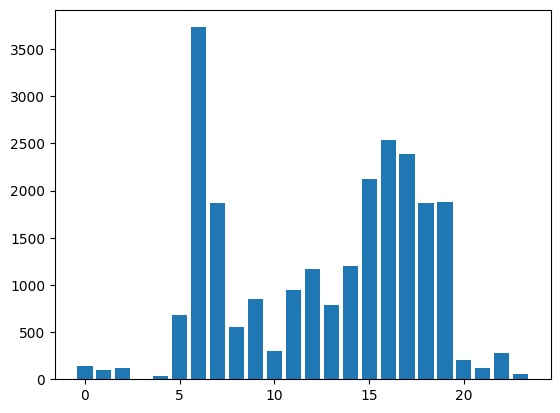

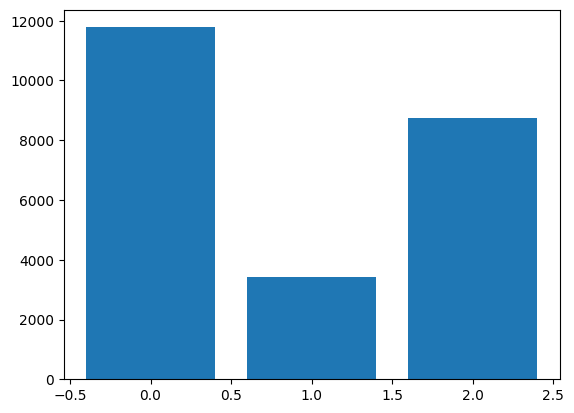

In [24]:
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
clips = os.listdir(clip_save_dir)
# format: {label}_2024-12-05-00-40-00_{frame}_{location}.mp4
# analyze hour distribution
hours = []
labels = []
for clip in clips:
    timestamp = clip.split("_")[1]
    hour = timestamp.split("-")[3]
    label = clip.split("_")[0]
    labels.append(int(label))
    hours.append(int(hour))
count_24 = np.zeros(24)
for hour in hours:
    count_24[hour] += 1
plt.bar(range(24), count_24)
plt.show()
extra_sample_number = 800 - count_24
extra_sample_number[extra_sample_number < 0] = 0
# sample the clips
empty_video_list = np.array(pd.read_excel(r'D:\LiDAR_Data\2ndPHB\Video\EmptyVideo.xlsx',header=None))
empty_video_list = np.array(empty_video_list).flatten()
# extract hour of the empty video
hour_empty_video = []
for video in empty_video_list:
    timestamp = video.split("_")[-1]
    hour = timestamp[:2]
    hour_empty_video.append(int(hour))
hour_empty_video = np.array(hour_empty_video)
for i in range(len(extra_sample_number)):
    if extra_sample_number[i] > 0:
        # sample the clips
        extra_number = extra_sample_number[i]
        empty_video_name = empty_video_list[hour_empty_video == i][0]
        empty_video_path = os.path.join(clip_save_dir, empty_video_name)
#count label distribution
count_label = np.zeros(3)
for label in labels:
    count_label[label] += 1
plt.bar(range(3), count_label)
plt.show()

In [17]:
import shutil
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Split the dataset into train, validation,test with 80%, 10%, 10% respectively
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
clips = os.listdir(clip_save_dir)
# Split the dataset into train, validation,test with 80%, 10%, 10% respectively
train_clips, test_clips = train_test_split(clips, test_size=0.2, random_state=42)
valid_clips, test_clips = train_test_split(test_clips, test_size=0.5, random_state=42)
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0114\train'
valid_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0114\valid'
test_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0114\test'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(valid_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
for clip in train_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(train_folder, clip)
    shutil.copy(src, dst)
for clip in valid_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(valid_folder, clip)
    shutil.copy(src, dst)
for clip in test_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(test_folder, clip)
    shutil.copy(src, dst)

In [ ]:
# empty video list
empty_video_list = np.array(pd.read_excel(r'D:\LiDAR_Data\2ndPHB\Video\EmptyVideo.xlsx',header=None))
empty_video_list = np.array(empty_video_list).flatten()
output_folder = r'D:\LiDAR_Data\2ndPHB\Video\NewSampledClips_0'
os.makedirs(output_folder, exist_ok=True)
video_folder = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo'
for i in range(len(empty_video_list)):
    print(f"Processing {i+1}/{len(empty_video_list)}")
    video_file = empty_video_list[i] + '.avi'
    video_path = os.path.join(video_folder, video_file)
    date_str = empty_video_list[i][-15:]
    # convert date_str from YYYYMMDD_HHMMSS to YYYY-MM-DD-HH-MM-SS
    date = datetime.strptime(date_str, "%Y%m%d_%H%M%S").strftime("%Y-%m-%d-%H-%M-%S")
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
    frame_num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    sampled_frames = np.random.choice(frame_num, 500, replace=False)
    end_frame = sampled_frames.max()
    initial_frame = sampled_frames.min()
    cap.set(cv2.CAP_PROP_POS_FRAMES, initial_frame)
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        continue
    L_frames = []
    R_frames = []
    frame_inds = []
    cur_frame = initial_frame
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        L_frame = frame[pt1_L[1]:pt2_L[1], pt1_L[0]:pt2_L[0]]
        R_frame = frame[pt1_R[1]:pt2_R[1], pt1_R[0]:pt2_R[0]]
        L_frames.append(L_frame)
        R_frames.append(R_frame)
        frame_inds.append(cur_frame)
        if cur_frame > end_frame:
            break
        cur_frame += 1
    cap.release()
    # crop the frames based on the sampled frames
    L_frames = np.array(L_frames)
    R_frames = np.array(R_frames)

    for j in tqdm(sampled_frames):
        start_frame = j
        end_frame = j + fps*3
        if end_frame > max(frame_inds):
            continue
        if start_frame < 0:
            continue
        start_frame = np.where(frame_inds == start_frame)[0][0]
        end_frame = np.where(frame_inds == end_frame)[0][0]
        
        L_clip = L_frames[start_frame:end_frame]
        R_clip = R_frames[start_frame:end_frame]
        save_name = f"0_{date}_{start_frame}_L.mp4"
        if os.path.exists(os.path.join(output_folder, save_name)):
            continue
        out_path = os.path.join(output_folder, save_name)
        out = cv2.VideoWriter(out_path, fourcc, fps, (frame_width, frame_height))
        for frame in L_clip:
            out.write(frame)
        out.release()
        save_name = f"0_{date}_{start_frame}_R.mp4"
        if os.path.exists(os.path.join(output_folder, save_name)):
            continue
        out_path = os.path.join(output_folder, save_name)
        out = cv2.VideoWriter(out_path, fourcc, fps, (frame_width, frame_height))
        for frame in R_clip:
            out.write(frame)
        out.release()

In [29]:
import shutil 
clip_folder = r'D:\LiDAR_Data\2ndPHB\Video\Clips'
sample_clip_folder = r'D:\LiDAR_Data\2ndPHB\Video\NewSampledClips_0'
clips = os.listdir(sample_clip_folder)
location = []
label = []
for clip in clips:
    location.append(clip[-5])
    label.append(clip[0])
location = np.array(location)
label = np.array(label)
sampled_clips = np.random.choice(clips, 20000, replace=False)
# copy the sampled clips to the train and val and test folders
for clip in sampled_clips:
    src = os.path.join(sample_clip_folder, clip)
    dst = os.path.join(clip_folder, clip)
    shutil.copy(src, dst)

In [30]:
import shutil 
clip_folder = r'D:\LiDAR_Data\2ndPHB\Video\Clips'
left_clip_folder = r'D:\LiDAR_Data\2ndPHB\Video\Clips_L'
os.makedirs(left_clip_folder, exist_ok=True)
right_clip_folder = r'D:\LiDAR_Data\2ndPHB\Video\Clips_R'
os.makedirs(right_clip_folder, exist_ok=True)
clips = os.listdir(clip_folder)
location = []
label = []
for clip in clips:
    if clip[-5] == 'R':
        dst = os.path.join(right_clip_folder, clip)
        shutil.copy(os.path.join(clip_folder, clip), dst)  
    else:
        dst = os.path.join(left_clip_folder, clip)  
        shutil.copy(os.path.join(clip_folder, clip), dst)  

In [31]:
import shutil
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Split the dataset into train, validation,test with 80%, 10%, 10% respectively
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips_L"
clips = os.listdir(clip_save_dir)
# Split the dataset into train, validation,test with 80%, 10%, 10% respectively
train_clips, test_clips = train_test_split(clips, test_size=0.2, random_state=42)
valid_clips, test_clips = train_test_split(test_clips, test_size=0.5, random_state=42)
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\train'
valid_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\valid'
test_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\test'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(valid_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
for clip in train_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(train_folder, clip)
    shutil.copy(src, dst)
for clip in valid_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(valid_folder, clip)
    shutil.copy(src, dst)
for clip in test_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(test_folder, clip)
    shutil.copy(src, dst)

In [32]:
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips_R"
clips = os.listdir(clip_save_dir)
# Split the dataset into train, validation,test with 80%, 10%, 10% respectively
train_clips, test_clips = train_test_split(clips, test_size=0.2, random_state=42)
valid_clips, test_clips = train_test_split(test_clips, test_size=0.5, random_state=42)
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\train'
valid_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\valid'
test_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\test'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(valid_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
for clip in train_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(train_folder, clip)
    shutil.copy(src, dst)
for clip in valid_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(valid_folder, clip)
    shutil.copy(src, dst)
for clip in test_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(test_folder, clip)
    shutil.copy(src, dst)

In [6]:
from Dataset import preprocessing,transform_aug,VideoDataset
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torchvision import models
import albumentations as A
from Model_Softmax import CNNLSTMWithAttention,FocalLoss,CNNLSTM
import torch.nn as nn
from torchvision import models
import torch
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support

torch.cuda.empty_cache()

In [2]:
# Custom Transform for Normalization
def create_data_loaders(train_dir, val_dir, batch_size=4, preprocess=None, augmentation=None):
    train_dataset = VideoDataset(train_dir, preprocess=preprocess, augmentation=augmentation)
    val_dataset = VideoDataset(val_dir, preprocess=preprocess)
    # test_dataset = VideoDataset(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [3]:
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\train'
# val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\valid'
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\test'
train_loader, val_loader = create_data_loaders(train_dir, test_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)
cnn_output_dim=512
lstm_hidden_dim=512
lstm_layers=1
num_classes = 3
# model = CNNLSTMWithAttention(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
model = CNNLSTM(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0128_FocalLoss_250x150_3class_512_Right_3CNN_noatt\model\best_model.pth"
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs,dim=1).cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
precision, recall, F1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=list(range(num_classes)))

Validation: 100%|██████████| 1052/1052 [00:54<00:00, 19.26it/s]


In [6]:
print(precision, recall, F1)

[0.99191542 0.96464646 0.96644295] [0.996875   0.93170732 0.9632107 ] [0.99438903 0.94789082 0.96482412]


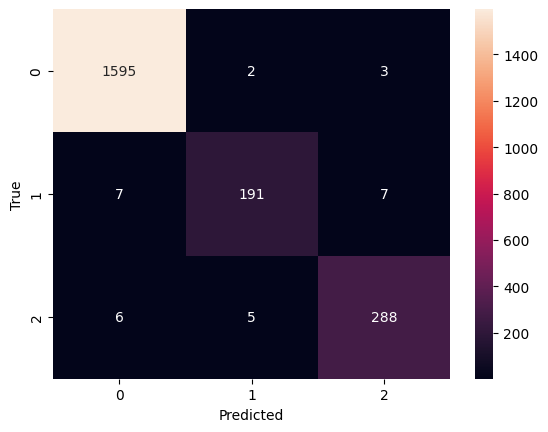

In [4]:
# plot graph of confusion matrix 
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\train'
# val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\valid'
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\test'
train_loader, val_loader = create_data_loaders(train_dir, test_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)
cnn_output_dim=512
lstm_hidden_dim=512
lstm_layers=1
num_classes = 3
model = CNNLSTMWithAttention(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
# model = CNNLSTM(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0123_FocalLoss_250x150_3class_512_Right_3CNN\model\best_model.pth"
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs, attention_weights = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs,dim=1).cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
precision, recall, F1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=list(range(num_classes)))

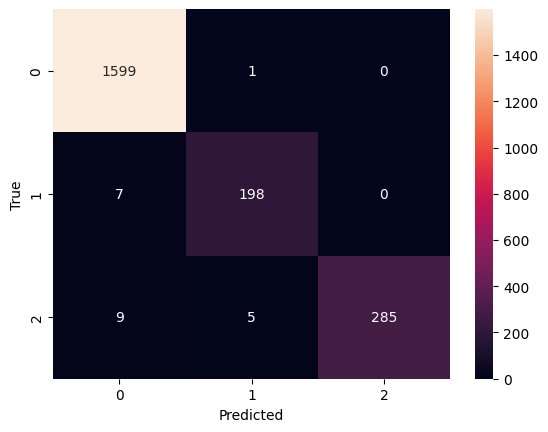

In [10]:
# plot graph of confusion matrix 
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
print(precision, recall, F1)

[0.99009288 0.97058824 1.        ] [0.999375   0.96585366 0.95317726] [0.99471229 0.96821516 0.9760274 ]


In [12]:
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\train'
# val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\valid'
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\test'
train_loader, val_loader = create_data_loaders(train_dir, test_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)
cnn_output_dim=512
lstm_hidden_dim=512
lstm_layers=1
num_classes = 3
model = CNNLSTMWithAttention(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
# model = CNNLSTM(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0123_FocalLoss_250x150_3class_512_Left_3CNN\model\best_model.pth"
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs, attention_weights = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs,dim=1).cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
precision, recall, F1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=list(range(num_classes)))

Validation: 100%|██████████| 1162/1162 [01:15<00:00, 15.37it/s]


In [13]:
print(precision, recall, F1)

[0.98310199 0.992      0.95933457] [0.99450549 0.85517241 0.96111111] [0.98877086 0.91851852 0.96022202]


In [14]:
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\train'
# val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\valid'
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\test'
train_loader, val_loader = create_data_loaders(train_dir, test_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)
cnn_output_dim=512
lstm_hidden_dim=512
lstm_layers=1
num_classes = 3
# model = CNNLSTMWithAttention(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
model = CNNLSTM(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0128_FocalLoss_250x150_3class_512_Left_3CNN_noatt\model\best_model.pth"
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs,dim=1).cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
precision, recall, F1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=list(range(num_classes)))

Validation: 100%|██████████| 1162/1162 [01:05<00:00, 17.78it/s]


In [15]:
print(precision, recall, F1)

[0.98423287 0.95192308 0.9122807 ] [0.99084249 0.68275862 0.96296296] [0.98752662 0.79518072 0.93693694]


### Inference

In [22]:
from Dataset import preprocessing,transform_aug,VideoDataset
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from torchvision import models
import albumentations as A
from Model_Softmax import CNNLSTMWithAttention,FocalLoss
import torch.nn as nn
from torchvision import models
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
mean = torch.tensor([0.485, 0.456, 0.406])  # Imagenet mean for RGB
std = torch.tensor([0.229, 0.224, 0.225])  # Imagenet std for RGB

In [23]:
frame_width,frame_height = 250,150
x,y = 500,750
pt1_L = (x, y)
pt2_L = (x+frame_width, y+frame_height)
x,y = 1450,840
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
x,y = 1000,840
pt1_M = (x, y)
pt2_M = (x+frame_width, y+frame_height)
ROI_L, ROI_R, ROI_M = [pt1_L, pt2_L], [pt1_R, pt2_R], [pt1_M, pt2_M]

In [24]:

model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0202_FocalLoss_250x150_3class_512_Left_3CNN\model\best_model.pth"
num_classes = 3
model_L = CNNLSTMWithAttention(cnn_output_dim=512,
    lstm_hidden_dim=512,
    lstm_layers=1,
    num_classes = 3).to(device)
model_L.load_state_dict(torch.load(model_path,weights_only=True))
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0202_FocalLoss_250x150_3class_512_Right_3CNN\model\best_model.pth"
model_R = CNNLSTMWithAttention(cnn_output_dim=512,
    lstm_hidden_dim=512,
    lstm_layers=1,
    num_classes = 3).to(device)
model_R.load_state_dict(torch.load(model_path,weights_only=True))
models = [model_L, model_R]


In [25]:
def predict(model, frames,device):
    model.eval()
    with torch.no_grad():
        frames = preprocessing(frames,device)
        # shape: (ROI, seq_len, c, h, w)
        outputs, attention_weights = model(frames)
        return outputs.cpu().numpy()

In [26]:
def preprocessing(cur_video,device):
    
    cur_video = np.array(cur_video).reshape((-1,150,250,3))
    cur_video = A.Equalize(p = 1)(images=cur_video)['images']
    cur_video = cur_video.reshape((-1,2,150,250,3))
    cur_video = torch.tensor(cur_video).to(device)
    cur_video = cur_video / 255.0
    cur_video = (cur_video - mean ) / std
    cur_video = cur_video.permute(1,0,4,2,3)
    # cur_video = cur_video.to(device)
    batch_size, seq_len, c, h, w = cur_video.size()
    x = cur_video.reshape(batch_size * seq_len, c, h, w) 
    x = x.view(batch_size, seq_len, c, h, w)
    return x

In [27]:
def preprocessing(cur_video,device,batch_size,frame_window):
    
    # cur_video_ = np.array(cur_video)
    batch_videos = []
    for i in range(batch_size):
        batch_videos.append(cur_video[i:i+frame_window])
    batch_videos = np.array(batch_videos) # batch_size, seq_len, [L,R] ,h, w, c
    batch_size, seq_len, _, h, w, c = batch_videos.shape
    batch_videos = batch_videos.reshape(-1,h,w,c)
    batch_videos = A.Equalize(p = 1)(images=batch_videos)['images']
    batch_videos = torch.tensor(batch_videos)
    batch_videos = batch_videos / 255.0
    batch_videos = (batch_videos - mean ) / std
    batch_videos = batch_videos.permute(0,3,1,2)
    batch_videos = batch_videos.view(batch_size,seq_len,2,c,h,w)
    return batch_videos.to(device)

def predict(models, batch_videos):
    predictions = []
    for i,model in enumerate(models):
        model.eval()
        with torch.no_grad():
            # shape: (ROI, seq_len, c, h, w)
            outputs, attention_weights = model(batch_videos[:,:,i])
            predictions.append(outputs.cpu().numpy())
    return predictions

In [31]:
# one model for N Rois
save_dir = r'D:\LiDAR_Data\2ndPHB\Video\test_out_0314'
os.makedirs(save_dir, exist_ok=True)
raw_video_dir = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo'
video_files = os.listdir(raw_video_dir)
# sample 20 videos for testing
# video_files = np.random.choice(video_files, 100, replace=False)
video_files = ['00_00_192.168.1.108_1_20241207_062000.avi']
frame_window = 30 # 3 seconds
batch_size = 8
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
font_color = (255, 255, 255)
line_type = 2
ROIs = [ROI_L, ROI_R]
for i in range(len(video_files)): 
    video_file = video_files[i]
    video_path = os.path.join(raw_video_dir, video_file.replace('.mp4','.avi'))
    # if not os.path.exists(video_path):
    #     continue
    save_path  = os.path.join(save_dir, video_file)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    raw_video_height, raw_video_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    p_bar = tqdm(total=total_frames - frame_window)
    total_rgb_frames = []
    while cap.isOpened():
        ret, cur_frame = cap.read()
        if not ret:
            break
        cur_raw_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
        frames_rgb_ROI = []
        for j,ROI in enumerate(ROIs):
            frame = cur_raw_frame_rgb[ROI[0][1]:ROI[1][1], ROI[0][0]:ROI[1][0]]
            frames_rgb_ROI.append(frame)
        frames_rgb_ROI = np.array(frames_rgb_ROI)
        total_rgb_frames.append(frames_rgb_ROI)
        p_bar.update(1)
    cap.release()
    del frame
    p_bar.clear()
    total_rgb_frames = np.array(total_rgb_frames)
        
    # batch_size = 4
    prediction_sequence = []
    for i in tqdm(range(frame_window,total_frames,batch_size)):
        frames = total_rgb_frames[i-frame_window:i + batch_size]
        batch_videos = []
        for j in range(batch_size):
            temp = frames[j:j+frame_window]
            # padding last frame 
            if len(temp) < frame_window:
                temp = np.concatenate([temp, [temp[-1]] * (frame_window - len(temp))])
            batch_videos.append(temp)
        batch_videos = np.array(batch_videos) # batch_size, seq_len, [L,R] ,h, w, c
        batch_size, seq_len, _, h, w, c = batch_videos.shape
        batch_videos = batch_videos.reshape(-1,h,w,c)
        batch_videos = A.Equalize(p = 1)(images=batch_videos)['images']
        batch_videos = torch.tensor(batch_videos)
        batch_videos = batch_videos / 255.0
        batch_videos = (batch_videos - mean ) / std
        batch_videos = batch_videos.permute(0,3,1,2)
        batch_videos = batch_videos.view(batch_size,seq_len,2,c,h,w)
        batch_videos = batch_videos.to(device)
        predictions = predict(models, batch_videos)
        prediction_sequence.append(predictions)
    prediction_sequence = np.array(prediction_sequence)
    left_preds = prediction_sequence[:,0,:,:].reshape(-1,3)
    right_preds = prediction_sequence[:,1,:,:].reshape(-1,3)
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_window)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(save_path, fourcc, fps, (raw_video_width, raw_video_height))
    frame_num = 0
    while cap.isOpened():
        ret, cur_frame = cap.read()
        if not ret:
            break
        cur_raw_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
        left_pred = left_preds[frame_num]
        right_pred = right_preds[frame_num]
        # digit to .2f
        left_pred = [f'{pred:.2f}' for pred in left_pred]
        right_pred = [f'{pred:.2f}' for pred in right_pred]
        # draw the text
        cur_frame = cv2.putText(cur_frame, f'Left: {left_pred}', (50, 50), font, font_scale, font_color, line_type)
        cur_frame = cv2.putText(cur_frame, f'Right: {right_pred}', (50, 100), font, font_scale, font_color, line_type)
        out.write(cur_frame)
        frame_num += 1
    out.release()
    cap.release()

2999it [16:41,  2.99it/s]00:00<?, ?it/s]
100%|██████████| 372/372 [01:37<00:00,  3.81it/s]   


In [15]:
video_files[0]

'00_00_192.168.1.108_1_20241208_140500.avi'

In [9]:
# one model for N Rois
save_dir = r'D:\LiDAR_Data\2ndPHB\Video\total_predictions_0124'
os.makedirs(save_dir, exist_ok=True)
raw_video_dir = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo'
video_files = os.listdir(raw_video_dir)
# sample 20 videos for testing
# video_files = np.random.choice(video_files, 100, replace=False)
frame_window = 30 # 3 seconds
batch_size = 8
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
font_color = (255, 255, 255)
line_type = 2
ROIs = [ROI_L, ROI_R]
for i in range(len(video_files)): 
    video_file = video_files[i]
    video_path = os.path.join(raw_video_dir, video_file)
    save_path  = os.path.join(save_dir, video_file.replace('.avi','.csv'))
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    raw_video_height, raw_video_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    # p_bar = tqdm(total=total_frames - frame_window)
    total_rgb_frames = []
    while cap.isOpened():
        ret, cur_frame = cap.read()
        if not ret:
            break
        cur_raw_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
        frames_rgb_ROI = []
        for j,ROI in enumerate(ROIs):
            frame = cur_raw_frame_rgb[ROI[0][1]:ROI[1][1], ROI[0][0]:ROI[1][0]]
            frames_rgb_ROI.append(frame)
        frames_rgb_ROI = np.array(frames_rgb_ROI)
        total_rgb_frames.append(frames_rgb_ROI)
        p_bar.update(1)
    cap.release()
    del frame
    # p_bar.clear()
    total_rgb_frames = np.array(total_rgb_frames)
        
    # batch_size = 4
    prediction_sequence = []
    for i in tqdm(range(frame_window,total_frames,batch_size)):
        frames = total_rgb_frames[i-frame_window:i + batch_size]
        batch_videos = []
        for j in range(batch_size):
            temp = frames[j:j+frame_window]
            # padding last frame 
            if len(temp) < frame_window:
                temp = np.concatenate([temp, [temp[-1]] * (frame_window - len(temp))])
            batch_videos.append(temp)
        batch_videos = np.array(batch_videos) # batch_size, seq_len, [L,R] ,h, w, c
        batch_size, seq_len, _, h, w, c = batch_videos.shape
        batch_videos = batch_videos.reshape(-1,h,w,c)
        batch_videos = A.Equalize(p = 1)(images=batch_videos)['images']
        batch_videos = torch.tensor(batch_videos)
        batch_videos = batch_videos / 255.0
        batch_videos = (batch_videos - mean ) / std
        batch_videos = batch_videos.permute(0,3,1,2)
        batch_videos = batch_videos.view(batch_size,seq_len,2,c,h,w)
        batch_videos = batch_videos.to(device)
        predictions = predict(models, batch_videos)
        prediction_sequence.append(predictions)
    prediction_sequence = np.array(prediction_sequence)
    left_preds = prediction_sequence[:,0,:,:].reshape(-1,3)
    right_preds = prediction_sequence[:,1,:,:].reshape(-1,3)
    cap.release()
    predictions = np.c_[left_preds,right_preds]
    # make df 
    df = pd.DataFrame(predictions,columns=['Left_Empty','Left_Crossing','Left_Activating','Right_Empty','Right_Crossing','Right_Activating'])
    df.to_csv(save_path,index=False)


100%|██████████| 373/373 [01:42<00:00,  3.65it/s]


In [99]:
# one model for N Rois
save_dir = r'D:\LiDAR_Data\2ndPHB\Video\test_out_256_NoHF'
os.makedirs(save_dir, exist_ok=True)
raw_video_dir = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo'
video_files = os.listdir(raw_video_dir)
# sample 20 videos for testing
video_files = np.random.choice(video_files, 50, replace=False)
frame_window = 30 # 3 seconds
batch_size = 4
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
font_color = (255, 255, 255)
line_type = 2
ROIs = [ROI_L, ROI_R]
for i in range(len(video_files)):
    video_file = video_files[i]
    video_path = os.path.join(raw_video_dir, video_file.replace('.mp4','.avi'))
    save_path  = os.path.join(save_dir, video_file)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    raw_video_height, raw_video_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

    out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (raw_video_width, raw_video_height))
    prediction_sequence = [] # store the predicted vectors
    cur_video = []
    for _ in range(frame_window + batch_size):
        ret, cur_raw_frame = cap.read()
        if not ret:
            break
        # for each frame, crop the frame within ROIs for prediction, shape: (ROI_ind,h,w,c)
        cur_raw_frame_rgb = cv2.cvtColor(cur_raw_frame, cv2.COLOR_BGR2RGB)
        frames_rgb_ROI = [] 
        for j,ROI in enumerate(ROIs):
            frame = cur_raw_frame_rgb[ROI[0][1]:ROI[1][1], ROI[0][0]:ROI[1][0]]
            frames_rgb_ROI.append(frame)
        frames_rgb_ROI = np.array(frames_rgb_ROI)
        cur_video.append(frames_rgb_ROI)
    cur_frame_ind = frame_window + batch_size
    batch_videos = preprocessing(cur_video,device,batch_size,frame_window)
    predictions = predict(models, batch_videos)
    # plot prediction value in right bottom corner of the raw frame and write to the video
    for j,ROI in enumerate(ROIs):
        str_draw = f"No Activity:{prediction[j,0]:.1f}|Crossing:{prediction[j,1]:.1f}|Activation:{prediction[j,2]:.1f}"
        cv2.putText(cur_raw_frame, str_draw, (ROI[0][1], ROI[1][1]), font, font_scale, font_color, line_type)
        # cv2.putText(cur_raw_frame, str(prediction[i]), (ROI[1][0], ROI[1][1]), font, font_scale, font_color, line_type)
    out.write(cur_raw_frame)
    prediction_sequence.append(prediction)



    p_bar = tqdm(total=total_frames - frame_window)
    while cap.isOpened():
        ret, cur_frame = cap.read()
        if not ret:
            break
        cur_raw_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
        frames_rgb_ROI = []
        for j,ROI in enumerate(ROIs):
            frame = cur_raw_frame_rgb[ROI[0][1]:ROI[1][1], ROI[0][0]:ROI[1][0]]
            frames_rgb_ROI.append(frame)
        frames_rgb_ROI = np.array(frames_rgb_ROI)
        cur_video.pop(0)
        cur_video.append(frames_rgb_ROI)
        prediction = predict(model, cur_video, device)
        for j,ROI in enumerate(ROIs):
            str_draw = f"No Activity:{prediction[j,0]:.1f}|Crossing:{prediction[j,1]:.1f}|Activation:{prediction[j,2]:.1f}"
            cv2.putText(cur_frame, str_draw, (ROI[0][0], ROI[1][1]), font, font_scale, font_color, line_type)
        out.write(cur_frame)
        prediction_sequence.append(prediction)
        p_bar.update(1)
    cap.release()
    out.release()
    p_bar.close()

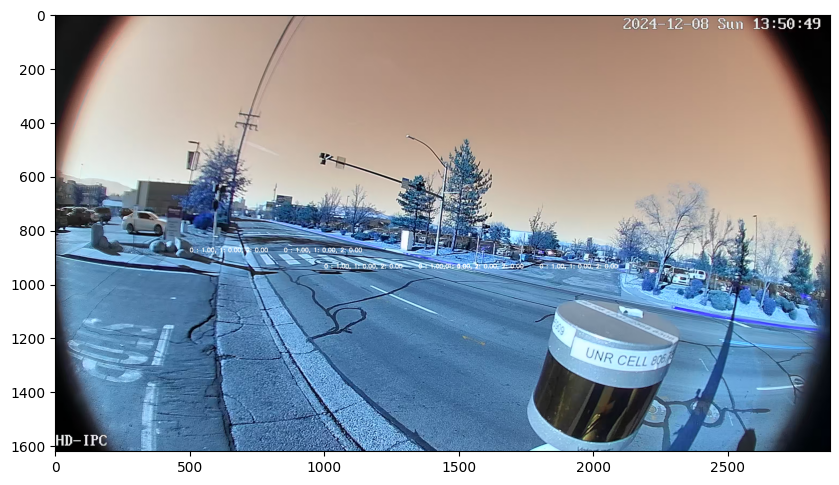

In [46]:
for i,ROI in enumerate(ROIs):
    str_draw = f"0 : {prediction[i,0]:.2f}, 1: {prediction[i,1]:.2f}, 2: {prediction[i,2]:.2f}"
    cv2.putText(cur_frame, str_draw, (ROI[0][0], ROI[1][1]), font, font_scale, font_color, line_type)
plt.figure(figsize=(10,10))
plt.imshow(cur_frame)
plt.show()

In [9]:
frame_width,frame_height = 250,150
x,y = 500,750
pt1_L = (x, y)
pt2_L = (x+frame_width, y+frame_height)
x,y = 1450,840
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
x,y = 1000,840
pt1_M = (x, y)
pt2_M = (x+frame_width, y+frame_height)
ROI_L, ROI_R, ROI_M = [pt1_L, pt2_L], [pt1_R, pt2_R], [pt1_M, pt2_M]

In [16]:
# one model for sinle ROI
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0114_FocalLoss_250x150_3class_256_Left\model\best_model.pth"
# model = ResNetLSTMWithAttention().to(device)
num_classes = 3
model = CNNLSTMWithAttention(cnn_output_dim=256,
    lstm_hidden_dim=256,
    lstm_layers=1,
    num_classes = 3).to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))

<All keys matched successfully>

In [ ]:
# one model for N Rois
save_dir = r'D:\LiDAR_Data\2ndPHB\Video\test_out_256_L'
os.makedirs(save_dir, exist_ok=True)
raw_video_dir = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo'
video_files = os.listdir(raw_video_dir)
# sample 20 videos for testing
video_files = np.random.choice(video_files, 50, replace=False)
frame_window = 30 # 3 seconds
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7
font_color = (255, 255, 255)
line_type = 2
ROIs = [ROI_L, ROI_R, ROI_M]
batch_size = 4
video_file = video_files[i]
video_path = os.path.join(raw_video_dir, video_file.replace('.mp4','.avi'))
save_path  = os.path.join(save_dir, video_file)
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
raw_video_height, raw_video_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (raw_video_width, raw_video_height))
prediction_sequence = [] # store the predicted vectors
cur_video = []
for _ in range(frame_window * batch_size):
    ret, cur_raw_frame = cap.read()
    if not ret:
        break
    # for each frame, crop the frame within ROIs for prediction, shape: (ROI_ind,h,w,c)
    cur_raw_frame_rgb = cv2.cvtColor(cur_raw_frame, cv2.COLOR_BGR2RGB)
    frames_rgb_ROI = [] 
    for j,ROI in enumerate(ROIs):
        frame = cur_raw_frame_rgb[ROI[0][1]:ROI[1][1], ROI[0][0]:ROI[1][0]]
        # if j == 1:
        #     frame = A.HorizontalFlip(p=1)(image=frame)['image'] 
        # frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames_rgb_ROI.append(frame)
    frames_rgb_ROI = np.array(frames_rgb_ROI)
    cur_video.append(frames_rgb_ROI)
cur_frame_ind = frame_window
prediction = predict(model, cur_video, device)